<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from arviz.utils import conditional_jit, Dask
from dask.distributed import Client
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Dask.enable_dask(dask_kwargs={"dask": "parallelized", "output_dtypes": [float]})
client = Client(threads_per_worker=4, n_workers=10, memory_limit="10GB")

In [3]:
import arviz as az

dan_prev = '../sfari/data/sra_shotgun/Dan2020/age_sex_matched_posterior/ogus_differentials.nc'
dan_curr = '../sfari/data/sra_shotgun/Dan2020/age_sex_matched_posterior/ogus_differentials-v2.nc'
dan_prev = az.InferenceData.from_netcdf(
    dan_prev, group_kwargs={'posterior':{'chunks': {'features': 100}}})
dan_curr = az.InferenceData.from_netcdf(
    dan_curr, group_kwargs={'posterior':{'chunks': {'features': 100}}})

In [5]:
dan_prev_rhat = az.rhat(dan_prev).compute()
dan_curr_rhat = az.rhat(dan_curr).compute()

In [6]:
client.close()

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


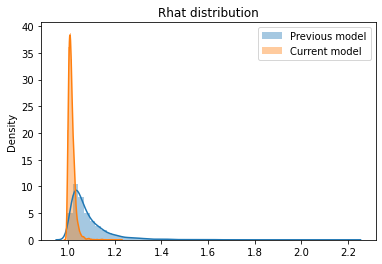

In [7]:
import seaborn as sns
sns.distplot(dan_prev_rhat['diff'].values, label='Previous model')
sns.distplot(dan_curr_rhat['diff'].values, label='Current model')
plt.title('Rhat distribution')
plt.legend()

In [8]:
!ls ../sfari/data/sra_shotgun/Dan2020/bioms

ogus.biom	     ogus_func-corrected.biom  species_func.biom
ogus-corrected.biom  species.biom	       virome.biom
ogus_func.biom	     species-corrected.biom


In [9]:
import biom
import pandas as pd
table = biom.load_table('../sfari/data/sra_shotgun/Dan2020/bioms/ogus-corrected.biom')

In [10]:
diff = dan_curr_rhat['diff'].to_dataframe()
diff = diff.rename(columns={'diff': 'rhat'})

In [11]:
total = pd.DataFrame({
    'total_reads': table.sum(axis='observation'), 
    'num_obs_samples': table.pa(inplace=False).sum(axis='observation')
}, index=table.ids(axis='observation'))

In [12]:
curr_stats = pd.merge(total, diff, left_index=True, right_index=True)

In [13]:
divergences = dan_curr.sample_stats.diverging.to_dataframe()
divergences = divergences.reset_index()
divergences = divergences.groupby('features').mean()
curr_stats['diverging'] = divergences['diverging']

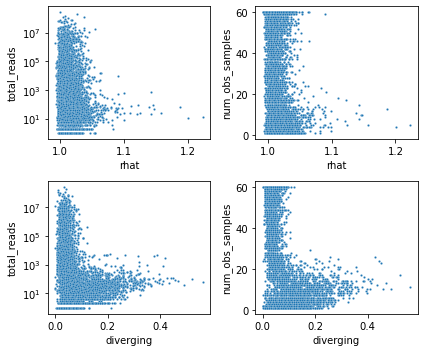

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(6, 5))
sns.scatterplot(data=curr_stats, x='rhat', y='total_reads', s=5, ax=ax[0, 0])
ax[0, 0].set_yscale('log')
sns.scatterplot(data=curr_stats, x='rhat', y='num_obs_samples', s=5, ax=ax[0, 1])

sns.scatterplot(data=curr_stats, x='diverging', y='total_reads', s=5, ax=ax[1, 0])
ax[1, 0].set_yscale('log')
sns.scatterplot(data=curr_stats, x='diverging', y='num_obs_samples', s=5, ax=ax[1, 1])
plt.tight_layout()

In [ ]:
sns.scatterplot(data=curr_stats, y='num_obs_samples', x='rhat', s=5)

In [ ]:
sns.scatterplot(data=curr_stats, y='num_obs_samples', x='diverging', s=5)

In [ ]:
sns.scatterplot(data=curr_stats, y='total_reads', x='diverging', s=5)
plt.yscale('log')